In [105]:
import tensorflow as tf
%load_ext tensorboard.notebook
import datetime, os

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [106]:
# CPU 수에 맞게 병렬 데이터 처리를 가능하게 해주는 옵션
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Dataset 다운로드 및 분석
## Image 가져오기
텐서플로에서 기본으로 제공하는 Dataset 중 하나인 flower_photos를 가져온다. 총 5종류,
3670장의 꽃 사진이 있습니다.

In [108]:
import pathlib
data_root_orig = tf.keras.utils.get_file('flower_photos',
                                         'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/Users/seungmoo/.keras/datasets/flower_photos


In [112]:
for item in data_root.iterdir():
    print(item)

/Users/seungmoo/.keras/datasets/flower_photos/roses
/Users/seungmoo/.keras/datasets/flower_photos/sunflowers
/Users/seungmoo/.keras/datasets/flower_photos/daisy
/Users/seungmoo/.keras/datasets/flower_photos/dandelion
/Users/seungmoo/.keras/datasets/flower_photos/tulips
/Users/seungmoo/.keras/datasets/flower_photos/LICENSE.txt


random.shuffle(all_image_pahts)를 입력해서 사진을 랜덤하게 섞어준다. Training 전에 데이터를 섞으면 variance를 줄일 수 있다.

In [115]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 사진을 랜덤하게 섞는다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [116]:
all_image_paths[:10]

['/Users/seungmoo/.keras/datasets/flower_photos/dandelion/19435491090_7af558e17e.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/sunflowers/2729206569_9dd2b5a3ed.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/dandelion/284497233_c19801752c.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/daisy/538920244_59899a78f8_n.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/sunflowers/5951665793_8ae4807cbd_n.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/roses/5602220566_5cdde8fa6c_n.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/dandelion/2472641499_cbe617a93d.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/dandelion/19617643201_9922eec796.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/daisy/20182559506_40a112f762.jpg',
 '/Users/seungmoo/.keras/datasets/flower_photos/daisy/12701063955_4840594ea6_n.jpg']

### Image 조사(EDA)

Training 전에 EDA를 하는 것은 굉장히 중요한 작업이다.

In [134]:
import os
attributions = (data_root/'LICENSE.txt').open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [140]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return 'Image (CC BY 2.0)' + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

In [141]:
caption_image(image_path)

'Image (CC BY 2.0) by Juan Manuel Barra Valdebenito'

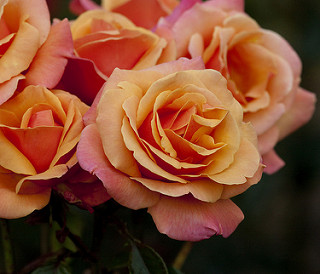

Image (CC BY 2.0) by William Murphy
roses



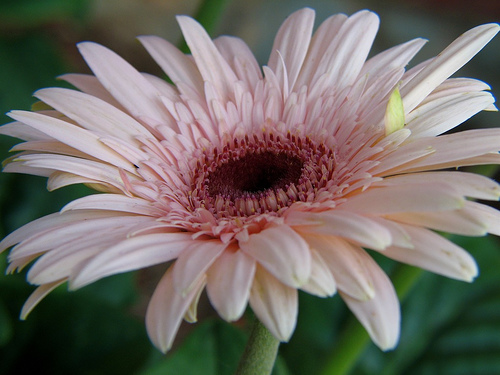

Image (CC BY 2.0) by Audrey
daisy



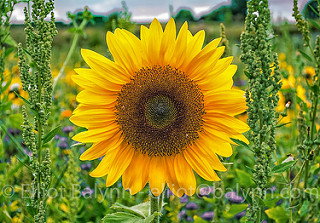

Image (CC BY 2.0) by Elliot Balynn
sunflowers



In [143]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print(image_path.split('/')[-2])
    print()

### 각 이미지의 라벨 결정

이 데이터에서는 폴더의 이름이 라벨의 이름이기 때문에, 먼저 폴더 이름의 리스트를 표시해본다.

In [179]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

리스트에 순서대로 index를 부여해서 dictionary로 만든다.

In [182]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

위에서 만든 label_to_index로 모든 이미지에 대해서 꽃 이름을 index로 치환시켜준다.

In [185]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]
print('First 10 labels indices: ', all_image_labels[:10])

First 10 labels indices:  [1, 3, 1, 0, 3, 2, 1, 1, 0, 0]


### Image Load, 정제
이제 Image 파일을 텐서플로로 Load하고 실제로 사용하기 위해 정제해보자

In [189]:
img_path = all_image_paths[0]
img_path

'/Users/seungmoo/.keras/datasets/flower_photos/dandelion/19435491090_7af558e17e.jpg'

RAW 데이터는 아래와 같은 모양이다. 즉시 실행 모드(eager) 덕분에 Session 실행 없이도 numpy 부분을 바로 확인할 수 있다.

In [193]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+'...')

<tf.Tensor: id=14675, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x...


이제 RAW 데이터를 텐서플로에서 사용할 image Tensor로 바꿔줍니다. scipy에서 Image를 import 해서 사용하는 등 복잡한 과정 없이, 함수 호출 한번으로 Image Tensor를 얻을 수 있다.

In [194]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(333, 500, 3)
<dtype: 'uint8'>


리사이즈도 tf.image에서 가능하다.

In [201]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final / 255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [207]:
img_final[:3]

<tf.Tensor: id=14744, shape=(3, 192, 3), dtype=float32, numpy=
array([[[0.8373979 , 0.67384696, 0.4362429 ],
        [0.8490838 , 0.692221  , 0.44908375],
        [0.86319506, 0.69991416, 0.46177012],
        ...,
        [0.77648556, 0.65491694, 0.43629915],
        [0.7693321 , 0.6507104 , 0.43284887],
        [0.75752646, 0.6330779 , 0.42131323]],

       [[0.8475359 , 0.6865151 , 0.4434567 ],
        [0.8566569 , 0.70019245, 0.45586035],
        [0.87058824, 0.7137255 , 0.47058824],
        ...,
        [0.7839196 , 0.65843356, 0.42617866],
        [0.7807292 , 0.64849013, 0.42127565],
        [0.76777244, 0.63051754, 0.41027075]],

       [[0.8517566 , 0.6886438 , 0.44628268],
        [0.86331284, 0.7103717 , 0.4554697 ],
        [0.8706224 , 0.71375966, 0.47062236],
        ...,
        [0.78695524, 0.6549154 , 0.4091232 ],
        [0.77525944, 0.64644414, 0.4032332 ],
        [0.7637968 , 0.6265419 , 0.40064338]]], dtype=float32)>

아래 함수들, preprocess_image, load_and_preprocess_image는 Dataset에 쓰인다.

In [208]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0 # normalize to [0, 1] range 
    return image

In [209]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

그래프 라이브러리인 matplotlib을 사용해서 Image 중 하나를 출력해볼 수 있다.

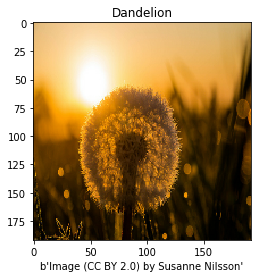

In [240]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

## tf.data.Dataset 만들기
### Image Dataset
tf.data.Dataset은 from_tensor_slices로 간단하게 만든다.

In [241]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

위에서 잠깐 봤던 load_and_preprocess_image 함수는 path를 받아서 image를 return 합니다. map으로 이 함수를 path Dataset에 적용시키면 새로운 image Dataset을 만들 수 있습니다.

In [247]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

image_ds.take(4)는 4만큼의 크기를 가진 새로운 Dataset을 반환한다.

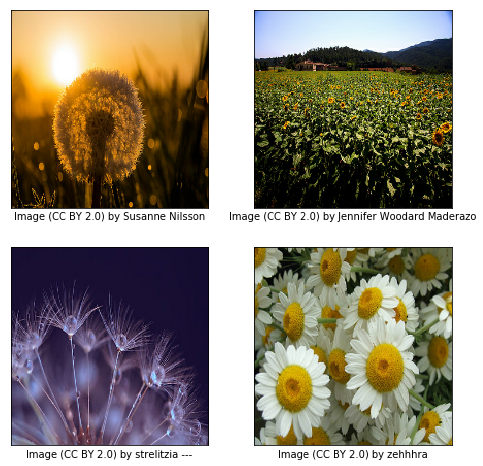

In [248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2, 2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

## (image, label) Dataset
라벨에 대해서도 Dataset을 만들 수 있습니다.

In [250]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels,tf.int64))
label_ds

<TensorSliceDataset shapes: (), types: tf.int64>

In [251]:
for label in label_ds.take(10):
    print(label.numpy(), label_names[label.numpy()])

1 dandelion
3 sunflowers
1 dandelion
0 daisy
3 sunflowers
2 roses
1 dandelion
1 dandelion
0 daisy
0 daisy


Image Dataset과 Label Dataset은 같은 순서를 가지고 있기 때문에 (처음에 한번 shuffle을 한 것 외에는 건드리면 안됨) python의 zip을 이용해서 하나의 (image, label)Dataset으로 묶을 수 있다.

In [269]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

zip으로 묶은(tf로 사용) 새로운 Dataset의 타입은 자동으로 ZipDataset이 된다.

In [270]:
type(image_label_ds)

tensorflow.python.data.ops.dataset_ops.ZipDataset

# Training을 위한 Dataset 처리
Dataset으로 Training을 실행하기 위해 우리가 꼭 해야할 것들이 있다.
- 랜덤하게 섞기
- 작은 BATCH로 쪼개기
- 끝없이 반복
- BATCH는 가능한 빠르게 사용 가능해져야 한다.

아래에서 tf.data.api를 사용하여 간단히 처리할 수 있다.

In [271]:
BATCH_SIZE = 32
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

# 신경망 Training에 Dataset 사용하기

### Simple CNN
이미지를 보고 라벨을 추측하는 문제를 처리하기 위해서 간단한 Convolutional Neural Network(CNN)를 구성, tf.keras를 사용해서 간단하게 CNN을 정의할 수 있다.

In [272]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(192,192,3), strides=(2,2), kernel_size=3, filters=16),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(strides=(2,2), kernel_size=3, filters=32),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(strides=(2,2), kernel_size=3, filters=64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 95, 95, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 23, 23, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

정의된 모델을 compile하면 Training을 시킬 준비가 끝납니다. optimizer, loss도 2.0에서 정리된 하나의 함수를 사용한다.

In [273]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

epoch 당 필요한 training step을 계산하기 위해서 전체 이미지의 수를 BATCH_SIZE로 나눈 다음 math.ceil 연산을 해줍니다.

In [274]:
import math
steps_per_epoch = math.ceil(len(all_image_paths) / BATCH_SIZE)
steps_per_epoch

115

### Dataset을 모델에 연결하기
이제 방금 정의한 CNN 모델에 Dataset을 연결해서 Training을 실행한다.

In [275]:
# 텐서보드에 log 정보를 전달하는 부분
logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

# 1 epoch가 끝날 때마다 텐서보드에 log 정보를 전달
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 실제 학습을 시키는 부분
model.fit(ds, epochs=10, steps_per_epoch=steps_per_epoch, callbacks=[tensorboard_callback])

Epoch 1/10
115/115 [==============================] - 15s 128ms/step - loss: 1.2412 - accuracy: 0.4823
Epoch 2/10
115/115 [==============================] - 8s 66ms/step - loss: 1.0520 - accuracy: 0.5818
Epoch 3/10
115/115 [==============================] - 8s 66ms/step - loss: 0.9496 - accuracy: 0.6264
Epoch 4/10
115/115 [==============================] - 8s 66ms/step - loss: 0.8321 - accuracy: 0.6804
Epoch 5/10
115/115 [==============================] - 7s 65ms/step - loss: 0.7677 - accuracy: 0.7125
Epoch 6/10
115/115 [==============================] - 8s 70ms/step - loss: 0.6681 - accuracy: 0.7470
Epoch 7/10
115/115 [==============================] - 8s 67ms/step - loss: 0.5604 - accuracy: 0.7970
Epoch 8/10
115/115 [==============================] - 8s 67ms/step - loss: 0.4740 - accuracy: 0.8361
Epoch 9/10
115/115 [==============================] - 8s 67ms/step - loss: 0.3888 - accuracy: 0.8639
Epoch 10/10
115/115 [==============================] - 8s 65ms/step - loss: 0.3151 - accu

## 텐서보드 확인하기
텐서보드를 colab과 jupyter notebook에서 직접 열어볼 수 있다.
accuracy는 점점 증가하고, loss는 점점 감소하는 것을 확인할 수 있다.

In [276]:
%tensorboard --logdir logs